In [ ]:
pip install --upgrade -r requirements.txt


📂 Running for fold_1...


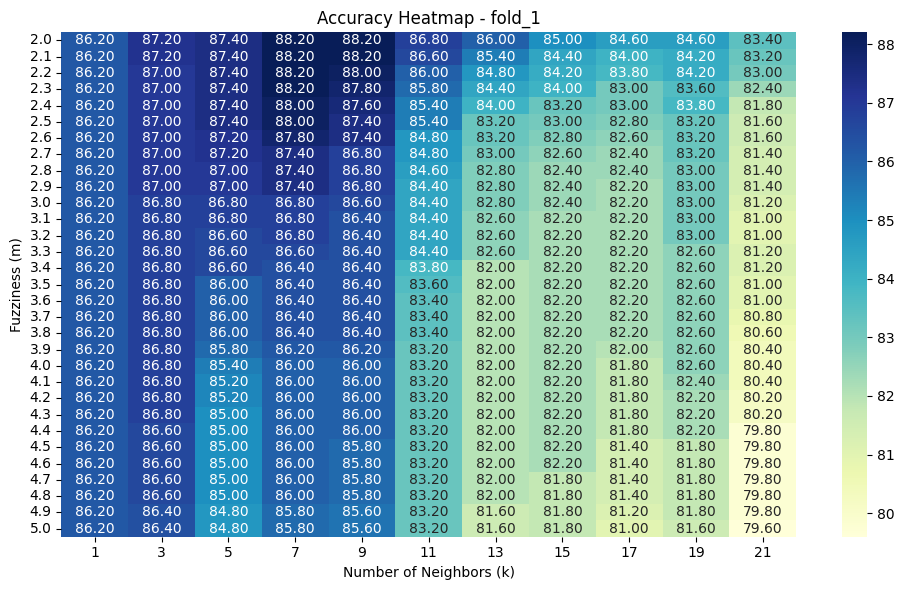


📊 Confusion Matrix for fold_1 (Best k=7, m=2.0):


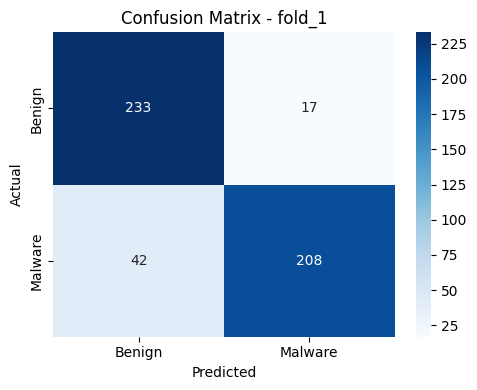


📂 Running for fold_2...


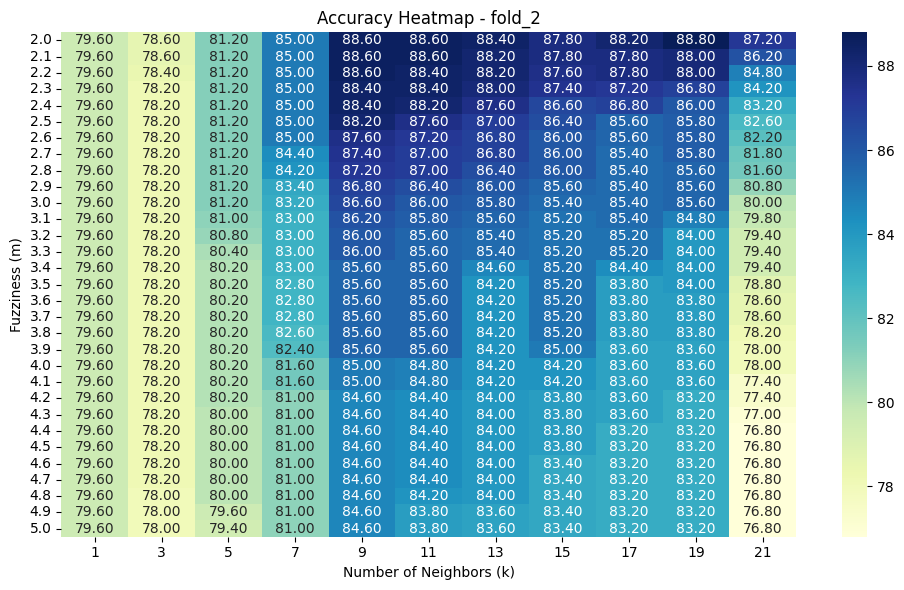


📊 Confusion Matrix for fold_2 (Best k=19, m=2.0):


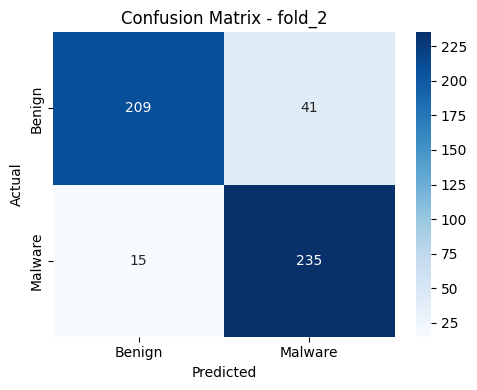


📂 Running for fold_3...


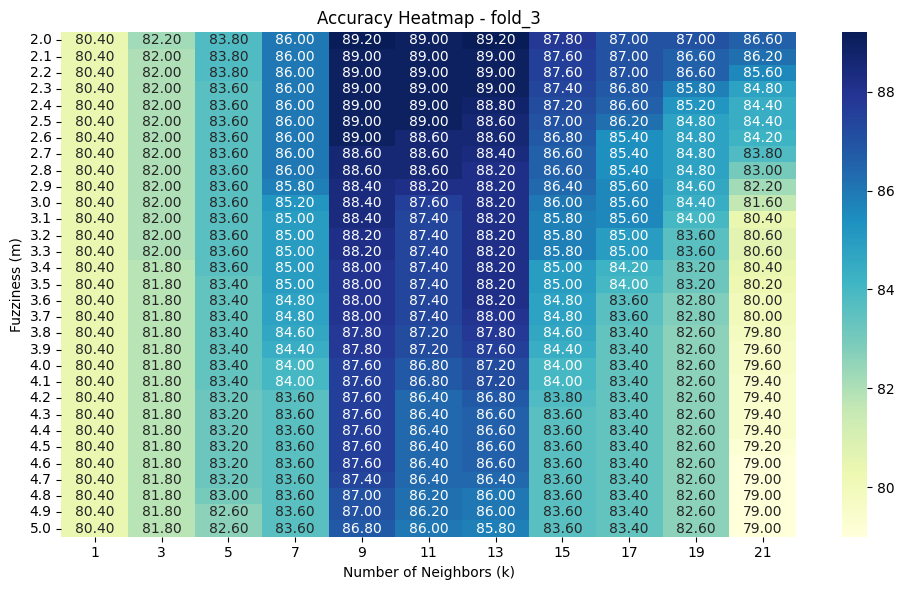


📊 Confusion Matrix for fold_3 (Best k=9, m=2.0):


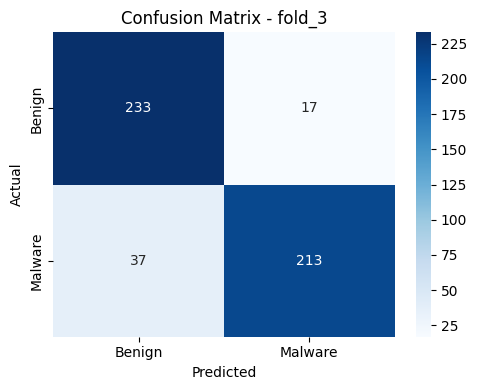


📂 Running for fold_4...


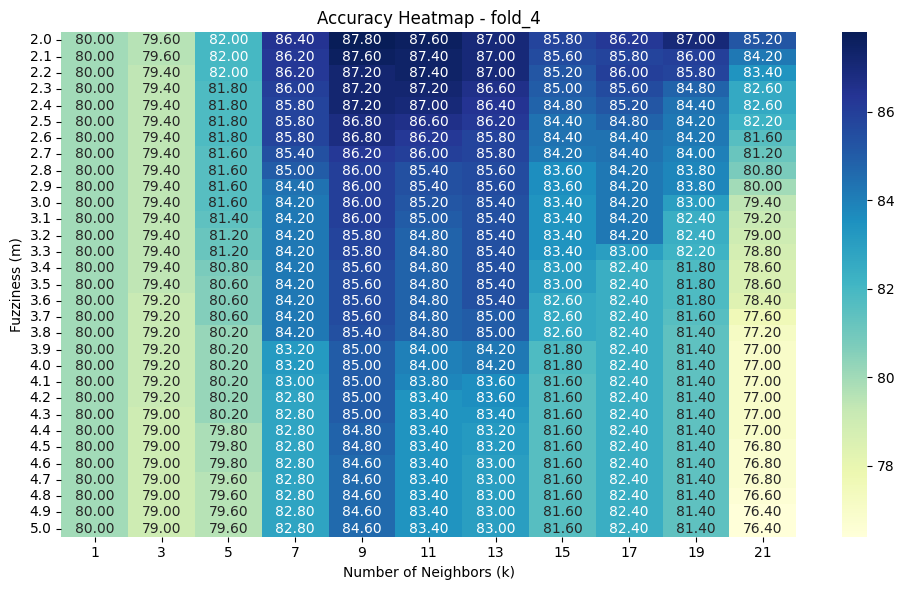


📊 Confusion Matrix for fold_4 (Best k=9, m=2.0):


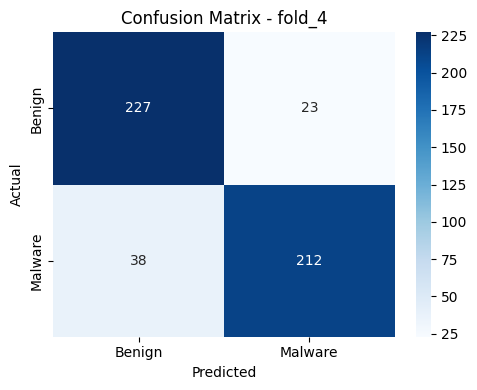


✅ สรุปผลการทดสอบทั้งหมด:
📂 fold_1 → Best k = 7, Best m = 2.0, Accuracy = 88.20%, Precision = 0.92, Recall = 0.83, F1 Score = 0.88
📂 fold_2 → Best k = 19, Best m = 2.0, Accuracy = 88.80%, Precision = 0.85, Recall = 0.94, F1 Score = 0.89
📂 fold_3 → Best k = 9, Best m = 2.0, Accuracy = 89.20%, Precision = 0.93, Recall = 0.85, F1 Score = 0.89
📂 fold_4 → Best k = 9, Best m = 2.0, Accuracy = 87.80%, Precision = 0.90, Recall = 0.85, F1 Score = 0.87

📄 summary_metrics.csv ได้ถูกบันทึกเรียบร้อยแล้ว ✅


In [1]:
import numpy as np
import pandas as pd
import json
from collections import defaultdict
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


class FuzzyKNN:
    def __init__(self, k=5, m=2):
        self.k = k
        self.m = m

    def predict(self, train_labels, test_labels, distance_matrix):
        N, M = distance_matrix.shape
        assert len(train_labels) == N, f"train_labels ต้องมีขนาด {N}"
        assert len(test_labels) == M, f"test_labels ต้องมีขนาด {M}"

        predictions = []

        for j in range(M):
            distances = distance_matrix[:, j]
            sorted_indices = np.argsort(distances)[:self.k]
            nearest_labels = train_labels[sorted_indices]
            nearest_distances = distances[sorted_indices]

            membership = defaultdict(float)
            if np.any(nearest_distances == 0):
                label = nearest_labels[np.argmin(nearest_distances)]
                predictions.append({label: 1.0})
                continue

            inv_distances = 1 / (nearest_distances ** (2 / (self.m - 1)))
            total_inv = np.sum(inv_distances)

            for i, label in enumerate(nearest_labels):
                membership[label] += inv_distances[i] / total_inv

            predictions.append(membership)

        predicted_labels = [max(membership, key=membership.get) for membership in predictions]

        df_results = pd.DataFrame({
            "Test Label": test_labels,
            "Predicted Label": predicted_labels
        })

        return df_results


def plot_confusion_matrix(true_labels, predicted_labels, fold_name):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Benign", "Malware"],
                yticklabels=["Benign", "Malware"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {fold_name}")
    plt.tight_layout()
    plt.show()


def run_fuzzy_knn(train_label_path, test_label_path, distance_matrix_path, fold_name, k_min=1, k_max=21, m_min=2, m_max=5):
    with open(train_label_path, "r", encoding="utf-8") as file:
        train_labels_data = json.load(file)

    with open(test_label_path, "r", encoding="utf-8") as file:
        test_labels_data = json.load(file)

    train_labels_df = pd.DataFrame(train_labels_data)
    test_labels_df = pd.DataFrame(test_labels_data)

    train_labels = train_labels_df.iloc[:, 1].to_numpy()
    test_labels = test_labels_df.iloc[:, 1].to_numpy()

    distance_matrix_df = pd.read_csv(distance_matrix_path, header=None)
    distance_matrix = distance_matrix_df.to_numpy()

    best_accuracy = 0
    best_k = None
    best_m = None
    best_result_df = None

    accuracy_grid = []

    for k in range(k_min, k_max + 1, 2):
        for m in np.arange(m_min, m_max + 0.1, 0.1):
            m = round(m, 1)
            fuzzy_knn = FuzzyKNN(k=k, m=m)
            df_results = fuzzy_knn.predict(train_labels, test_labels, distance_matrix)

            acc = accuracy_score(df_results["Test Label"], df_results["Predicted Label"]) * 100
            accuracy_grid.append((k, m, acc))

            if acc > best_accuracy:
                best_accuracy = acc
                best_k = k
                best_m = m
                best_result_df = df_results

    # 🔥 วาด Heatmap Accuracy vs k/m
    accuracy_df = pd.DataFrame(accuracy_grid, columns=["k", "m", "Accuracy"])
    heatmap_data = accuracy_df.pivot(index="m", columns="k", values="Accuracy")

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Accuracy Heatmap - {fold_name}")
    plt.ylabel("Fuzziness (m)")
    plt.xlabel("Number of Neighbors (k)")
    plt.tight_layout()
    plt.show()

    # 🎯 Metrics
    y_true = best_result_df["Test Label"]
    y_pred = best_result_df["Predicted Label"]

    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    print(f"\n📊 Confusion Matrix for {fold_name} (Best k={best_k}, m={best_m}):")
    plot_confusion_matrix(y_true, y_pred, fold_name)

    return best_k, best_m, best_accuracy, precision, recall, f1


if __name__ == "__main__":
    folds = ["fold_1", "fold_2", "fold_3", "fold_4"]
    base_path = "C:/Users/BMEi/Documents/GitHub/WORK/Windows/CODE_BME/PROJECT_CYBER_SECURITY/RESULT"

    results = []

    for fold in folds:
        train_label_path = f"{base_path}/05.DATA_VALIDATION/{fold}/MALWARE_100_BENIGN_100/validation_train.json"
        test_label_path = f"{base_path}/05.DATA_VALIDATION/{fold}/MALWARE_100_BENIGN_100/validation_test.json"
        distance_matrix_path = f"{base_path}/06.EDIT_DISTANCE_VALIDATION/{fold}/MATRIX_EDIT_DISTANCE_MALWARE_100_BENIGN_100.csv"

        print(f"\n📂 Running for {fold}...")
        best_k, best_m, best_accuracy, precision, recall, f1 = run_fuzzy_knn(
            train_label_path, test_label_path, distance_matrix_path, fold_name=fold
        )

        results.append({
            "Fold": fold,
            "Best k": best_k,
            "Best m": best_m,
            "Best Accuracy (%)": round(best_accuracy, 2),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1 Score": round(f1, 4)
        })

    print("\n✅ สรุปผลการทดสอบทั้งหมด:")
    for result in results:
        print(
            f"📂 {result['Fold']} → Best k = {result['Best k']}, Best m = {result['Best m']}, "
            f"Accuracy = {result['Best Accuracy (%)']:.2f}%, "
            f"Precision = {result['Precision']:.2f}, "
            f"Recall = {result['Recall']:.2f}, "
            f"F1 Score = {result['F1 Score']:.2f}"
        )

    # Export to CSV
    summary_df = pd.DataFrame(results)
    summary_df.to_csv("summary_metrics.csv", index=False)
    print("\n📄 summary_metrics.csv ได้ถูกบันทึกเรียบร้อยแล้ว ✅")